In [1]:
from helpers.SimulationAnalysis import readHlist
import pandas as pd
from helpers.io_utils import hlist2pandas
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

In [2]:
#halo_id = halos['id']
def get_particles(halo,host_id = None):
    #Get Halo info
    data = hlist2pandas('/Users/lmezini/proj_2/Halos_Recalculated/{}/out_0.list'.format(halo))
    ##make keys all lowercase letters
    halos = data.rename(columns={c: c.lower() for c in data.columns})
    if host_id is None:
        host_id = halos.at[halos['mvir'].idxmax(), 'id'] #get ID of most massive halo
        print(host_id)
    host = next(halos.query('id == {}'.format(host_id)).itertuples()) #get host info from table
    #get distance to host
    halos['dist_to_host'] = halos.eval('sqrt((x-@host.x)**2 + (y-@host.y)**2 + (z-@host.z)**2)')
    #find where the distance to host is less than rvir*0.002
    halos = halos.query('dist_to_host < (@host.rvir*0.002)') 
    halo_ids = set(halos['id'].tolist())
    part_table_header = 'x y z vx vy vz particle_id assigned_internal_haloid internal_haloid external_haloid'.split()
    part_table = StringIO() #create a file object for the particle table
    with open('MWM_particles/{}/halos_0.0.particles'.format(halo)) as f:
        for l in f:
            #pass all rows not associated with particle table
            if l[0]=='#':
                continue
            #check if external_haloid of particles == halo_id to match particles to halos    
            eid = int(l.strip().rpartition(' ')[-1])
            if eid in halo_ids:
                part_table.write(l)
    part_table.seek(0)
    particles=pd.read_csv(part_table, names = part_table_header,
        dtype=dict([(n, np.int if n.endswith('id') else np.float) for n in part_table_header]),
        engine='c', delim_whitespace=True, header=None, skipinitialspace=True,
        na_filter=False, quotechar=' '
            )
    del part_table
    particles_host = particles[particles['external_haloid'] == host.id]
    particles = particles[['particle_id', 'external_haloid']]
    particles = pd.merge(particles, halos[['id', 'vmax']], 
                         left_on='external_haloid', right_on='id')
    particles = particles.sort_values('vmax')
    particles = particles[['particle_id', 'external_haloid']]
    particles = particles[~particles.duplicated('particle_id')]
    particles = particles.rename(columns={'external_haloid': 'smallest_external_haloid'})
    particles_host = pd.merge(particles_host, particles, how='left', on='particle_id')
    particles_host['dist_to_host'] = particles_host.eval('sqrt((x-@host.x)**2 + (y-@host.y)**2 + (z-@host.z)**2)')

    return particles_host

In [156]:
get_particles('Halo023',None)


29189


,x,y,z,vx,vy,vz,assigned_internal_haloid,internal_haloid,external_haloid,particle_id,smallest_external_haloid,dist_to_host


In [158]:
data = hlist2pandas('/Users/lmezini/proj_2/Halos_Recalculated/{}/out_0.list'.format('halo530'))
data[data['ID']==29189]

,ID,DescID,Mvir,Vmax,Vrms,Rvir,Rs,Np,X,Y,...,c_to_a_ES,A[x]_ES,A[y]_ES,A[z]_ES,b_to_a(500c)_ES,c_to_a(500c)_ES,A[x](500c)_ES,A[y](500c)_ES,A[z](500c)_ES,Rs_ES
29330,29189,-1,62318000.0,9.29,7.64,8.145,0.208,252.0,55.94569,62.20426,...,0.76259,0.48946,-0.02266,0.20672,0.81234,0.68146,0.40935,0.02371,0.25905,0.20794


In [35]:
#separate particles between hosts and sub halos
host_ptcls = df[df.internal_haloid == df.assigned_internal_haloid]
#sub_ptcls = df[df.internal_haloid == df.assigned_internal_haloid]

In [14]:
particles = df[['particle_id', 'external_haloid']]
particles = pd.merge(particles, halos[['id', 'vmax']], left_on='external_haloid', right_on='id')
particles = particles.sort_values('vmax')

In [15]:
particles = particles[['particle_id', 'external_haloid']]
particles = particles[~particles.duplicated('particle_id')]
particles = particles.rename(columns={'external_haloid': 'smallest_external_haloid'})

In [16]:
host_ptcls = pd.merge(host_ptcls, particles, how='left', on='particle_id')

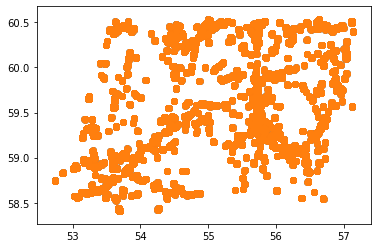

In [17]:
plt.scatter(host_ptcls.x,host_ptcls.y)
plt.scatter(df.x,df.y)